In [1]:
%load_ext pretty_jupyter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [5]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [8]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [9]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [10]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [11]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [12]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Read previous, non-tracked labels
We ran a preliminary analysis of our dataset that wasn't tracked for reproducibility. Here, we'll retrieve the labels for visualization and comparison to check for consistency.

In [13]:
original_uuid = '3868592c-0087-4ed8-98b2-4bf1b8676111'
original_df = read_parquet_uuid(original_uuid)
original_df = original_df[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
original_df = original_df.rename({'AIFI_L1': 'original_L1', 'AIFI_L2': 'original_L2', 'AIFI_L3': 'original_L3'}, axis = 1)

In [14]:
original_df.head()

barcodes original_L1 original_L2 original_L3
0  05ea9806794211eb93b836d1cb6129eb          DC        cDC1        cDC1
1  e225c914794011eb9282e2ceeb91ba52          DC        cDC1        cDC1
2  b1379eae795411eb958b0245821e6993          DC        cDC1        cDC1
3  b13d3a8a795411eb958b0245821e6993          DC        cDC1        cDC1
4  b1430d16795411eb958b0245821e6993          DC        cDC1        cDC1

## Markers for dotplots

In [15]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'IL7R', # T cells
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [16]:
class_markers = [
    'CD44'
]

## Read cell type hierarchy

In [17]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [18]:
search_id = 'germanium-einsteinium-indium'

Retrieve files stored in our HISE project store

In [19]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [20]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [21]:
search_df['AIFI_L3'].tolist()

['BaEoMaP cell', 'CLP cell', 'CMP cell', 'Erythrocyte', 'Platelet']

## Review BaEoMaP cell

In [22]:
cell_type = 'BaEoMaP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [23]:
type_uuid

'84b4de9b-3bad-4a0e-b345-ee95b45f1e23'

In [24]:
adata = read_adata_uuid(type_uuid)

### Clustering

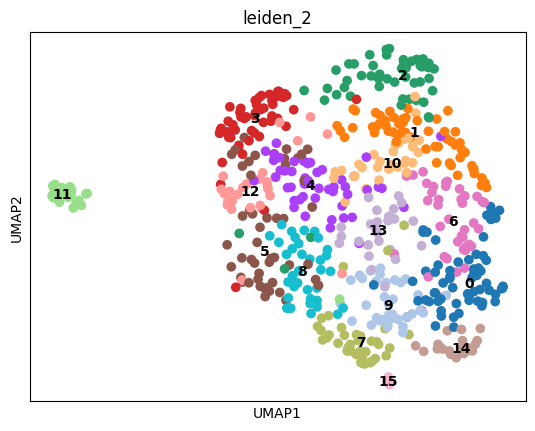

In [25]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

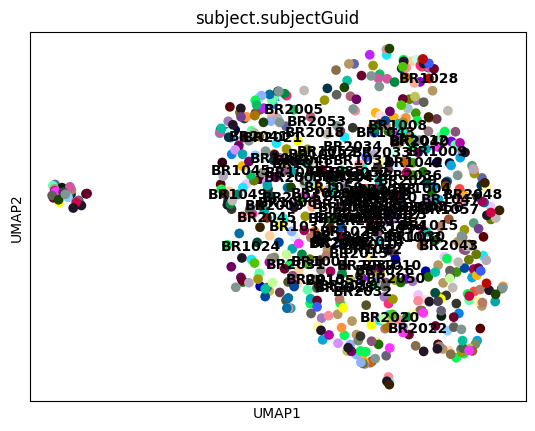

In [26]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

### Marker expression

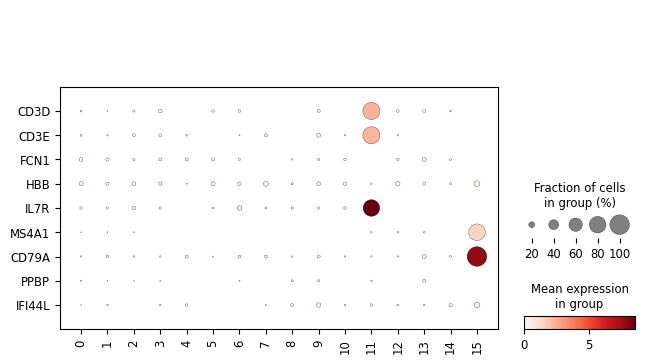

In [27]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [28]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     63
1     56
2     54
3     54
4     48
5     48
6     40
7     38
8     37
9     35
10    30
11    30
12    29
13    25
14    22
15     5
Name: count, dtype: int64

### Comparison to original labels

In [29]:
adata = add_labels(adata, original_df)

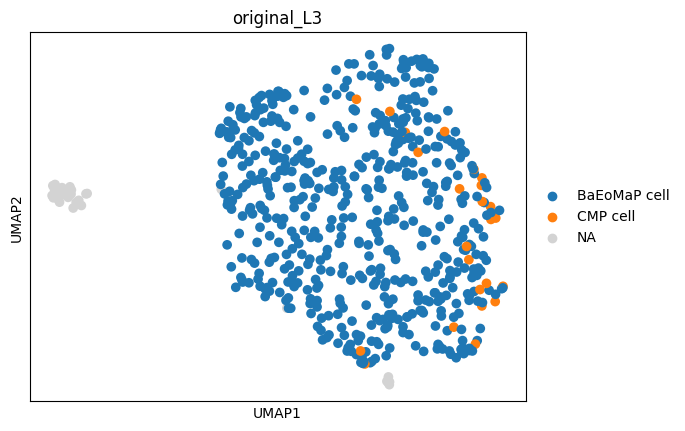

In [30]:
sc.pl.umap(adata, color = 'original_L3')

In [31]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
BaEoMaP cell    554
NaN              36
CMP cell         24
Name: count, dtype: int64

In [32]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
BaEoMaP cell    0.902280
NaN             0.058632
CMP cell        0.039088
Name: count, dtype: float64

### Suggested updates
- Remove CD3D+ cluster (11) as T cell doublet
- Remove MS4A1+ cluster (15) as B cell doublet

## Review CLP cell

In [33]:
cell_type = 'CLP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [34]:
type_uuid

'bf5350bd-0aff-468e-9736-c3baea442fd8'

In [35]:
adata = read_adata_uuid(type_uuid)

### Clustering

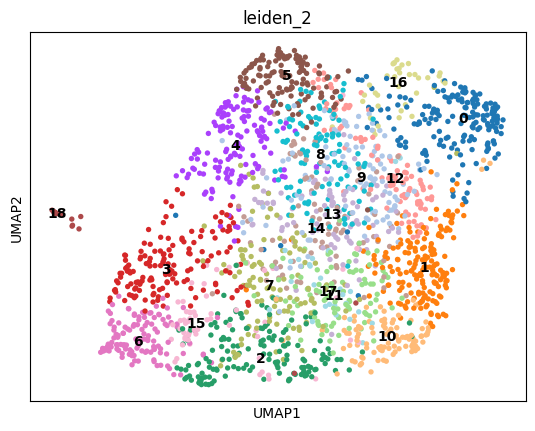

In [36]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

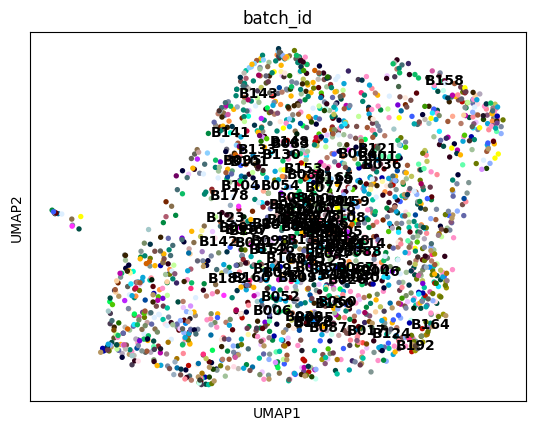

In [37]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

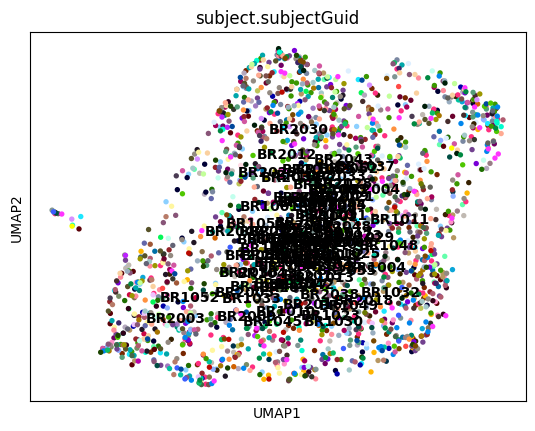

In [38]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

### Marker expression

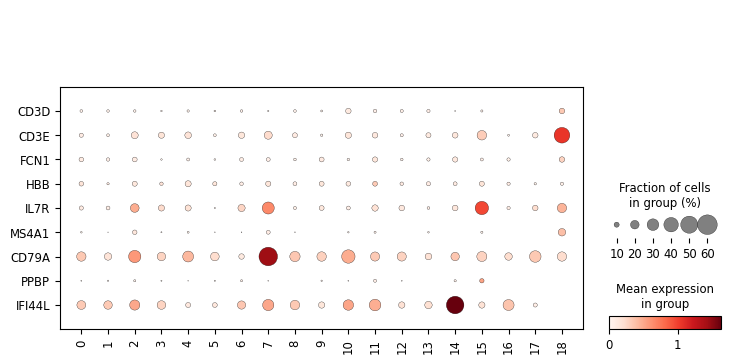

In [39]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

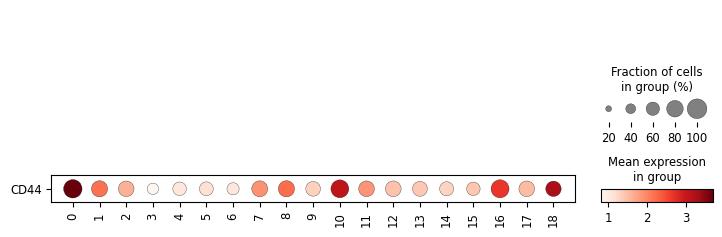

In [40]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

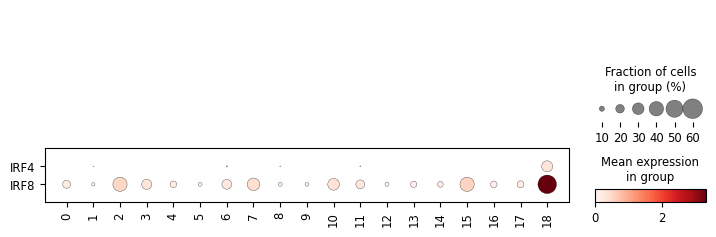

In [41]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['IRF4', 'IRF8'], swap_axes = True)

### Cluster counts

In [42]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     183
1     172
2     152
3     149
4     142
5     129
6     127
7     115
8     114
9     106
10    100
11     97
12     97
13     91
14     87
15     61
16     36
17     27
18     18
Name: count, dtype: int64

### Comparison to original labels

In [43]:
adata = add_labels(adata, original_df)

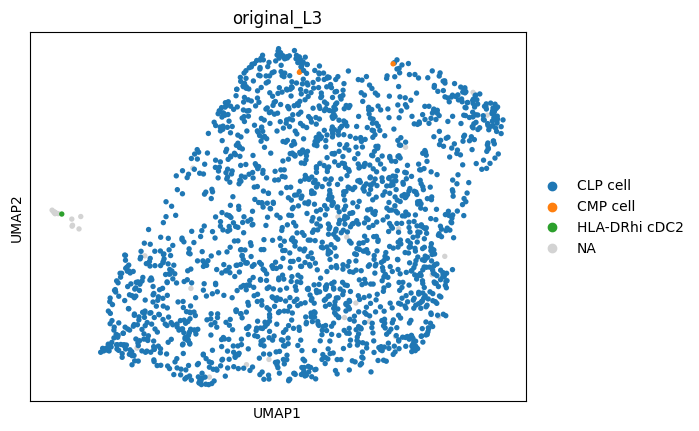

In [44]:
sc.pl.umap(adata, color = 'original_L3')

In [45]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CLP cell         1955
NaN                44
CMP cell            3
HLA-DRhi cDC2       1
Name: count, dtype: int64

In [46]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CLP cell         0.976036
NaN              0.021967
CMP cell         0.001498
HLA-DRhi cDC2    0.000499
Name: count, dtype: float64

### Suggested updates
- Remove CD3E+/IRF8+ cluster (18) as DC doublet

## Review CMP cell

In [47]:
cell_type = 'CMP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [48]:
type_uuid

'9b23db05-6e1f-45df-b01e-0bbaa5a0280b'

In [49]:
adata = read_adata_uuid(type_uuid)

### Clustering

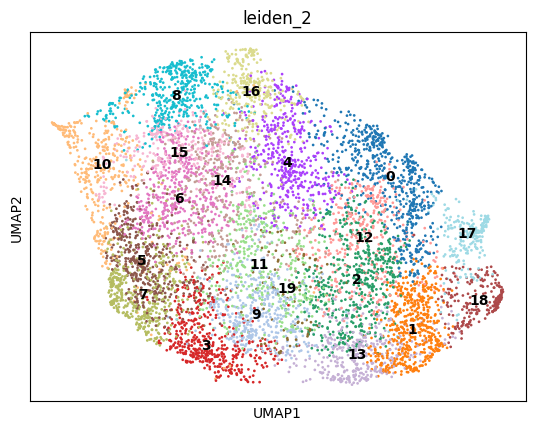

In [50]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

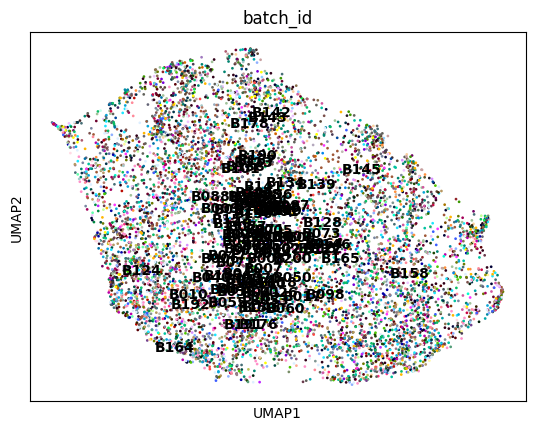

In [51]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

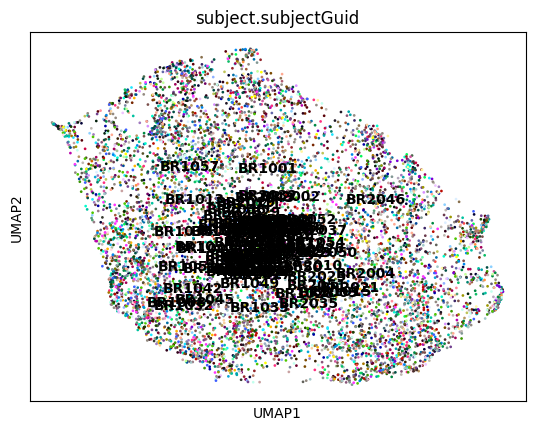

In [52]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

### Marker expression

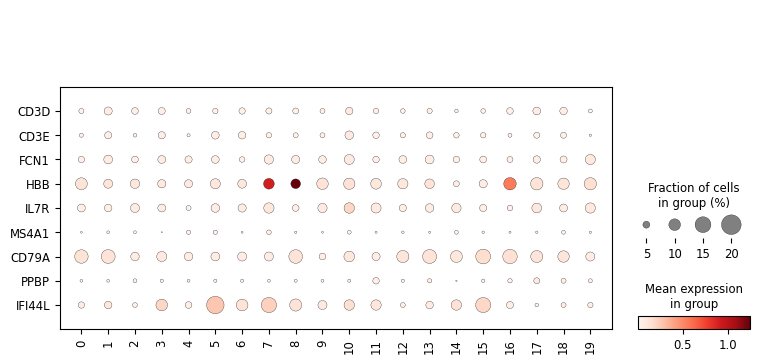

In [53]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

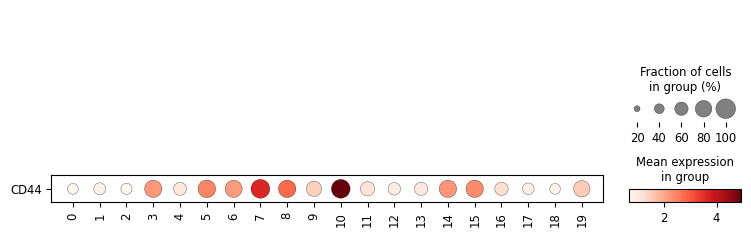

In [54]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [55]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     605
1     541
2     518
3     473
4     458
5     451
6     450
7     450
8     439
9     437
10    406
11    391
12    379
13    377
14    350
15    306
16    295
17    240
18    217
19     84
Name: count, dtype: int64

### Comparison to original labels

In [56]:
adata = add_labels(adata, original_df)

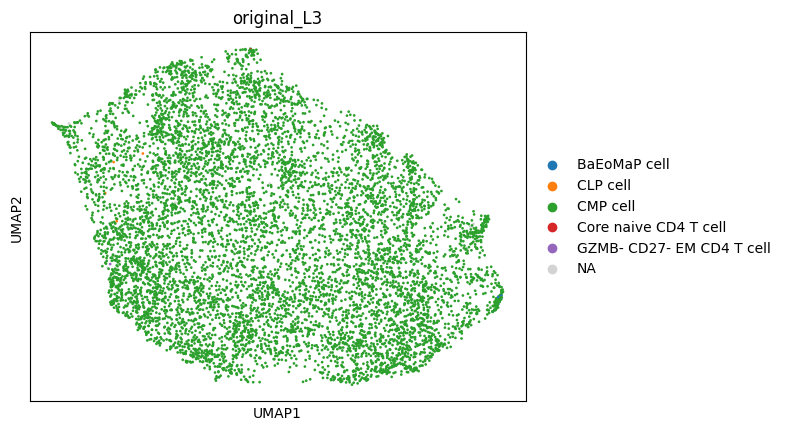

In [57]:
sc.pl.umap(adata, color = 'original_L3')

In [58]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CMP cell                     7839
NaN                            17
BaEoMaP cell                    5
CLP cell                        4
Core naive CD4 T cell           1
GZMB- CD27- EM CD4 T cell       1
Name: count, dtype: int64

In [59]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CMP cell                     0.996441
NaN                          0.002161
BaEoMaP cell                 0.000636
CLP cell                     0.000508
Core naive CD4 T cell        0.000127
GZMB- CD27- EM CD4 T cell    0.000127
Name: count, dtype: float64

### Suggested updates
No changes suggested

## Review Erythrocyte

In [60]:
cell_type = 'Erythrocyte'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [61]:
type_uuid

'69447a1b-0f14-4554-8909-f8992b88d785'

In [62]:
adata = read_adata_uuid(type_uuid)

### Clustering

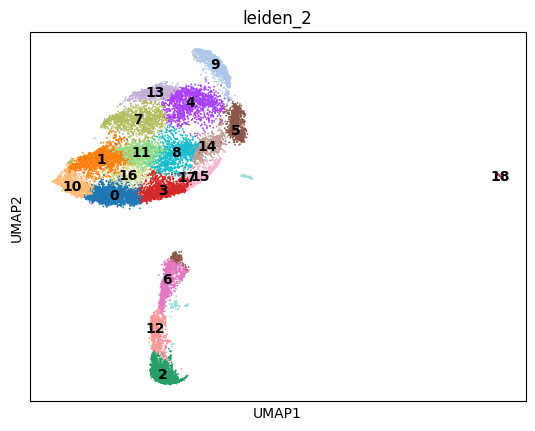

In [63]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

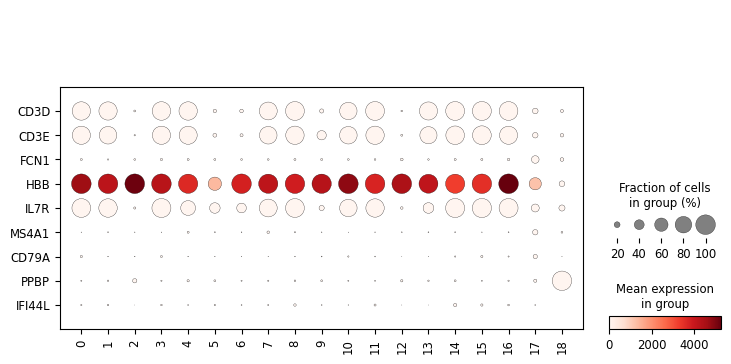

In [64]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

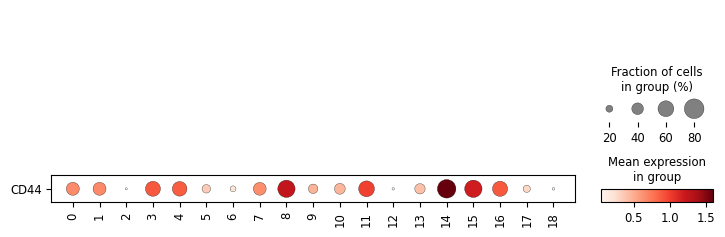

In [65]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

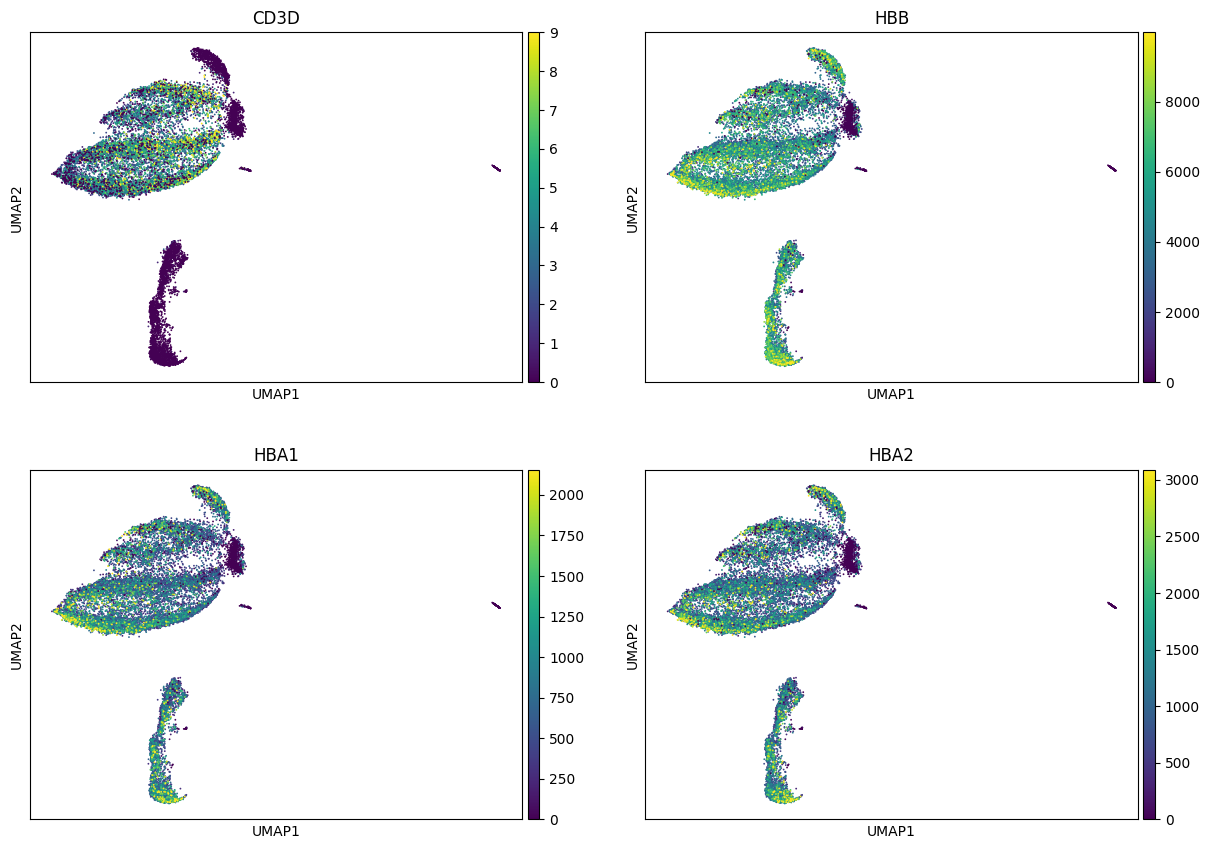

In [66]:
sc.pl.umap(adata, color = ['CD3D','HBB','HBA1','HBA2'], vmax = 'p99', ncols = 2)

### Cluster counts

In [67]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1482
1     1334
2     1305
3     1305
4     1259
5     1204
6     1160
7     1133
8     1103
9     1056
10     993
11     976
12     800
13     655
14     627
15     541
16     340
17     180
18     166
Name: count, dtype: int64

### Comparison to original labels

In [68]:
adata = add_labels(adata, original_df)

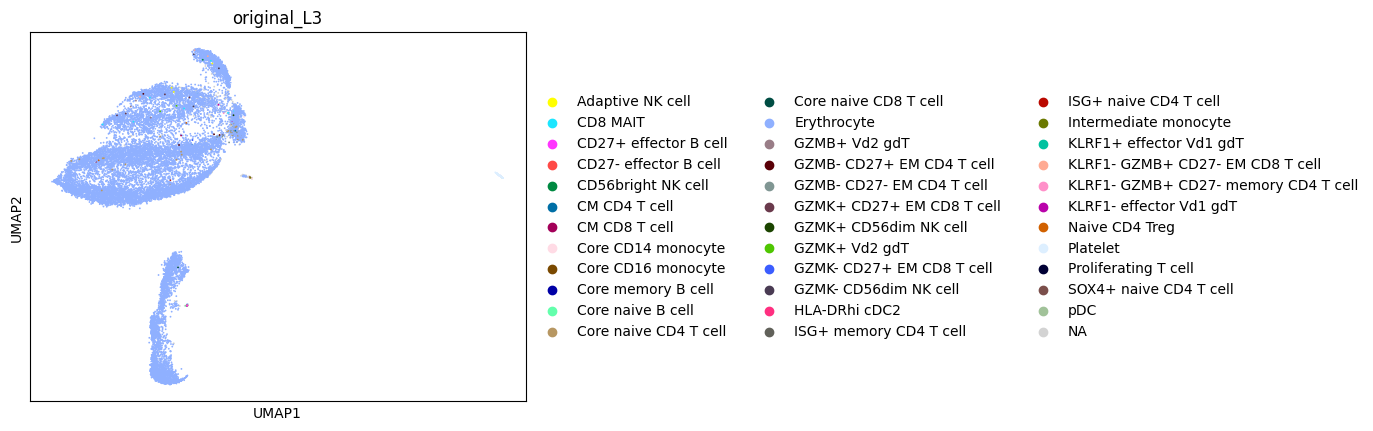

In [69]:
sc.pl.umap(adata, color = 'original_L3')

In [70]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Erythrocyte                             16797
NaN                                       509
Platelet                                  156
Core naive CD4 T cell                      60
GZMB- CD27- EM CD4 T cell                  14
CD8 MAIT                                    9
Core CD14 monocyte                          9
Core naive B cell                           9
GZMB- CD27+ EM CD4 T cell                   5
KLRF1- GZMB+ CD27- EM CD8 T cell            4
CM CD4 T cell                               4
Core CD16 monocyte                          4
GZMK+ CD27+ EM CD8 T cell                   4
GZMK- CD56dim NK cell                       3
Adaptive NK cell                            3
GZMB+ Vd2 gdT                               3
CD27- effector B cell                       2
Core memory B cell                          2
GZMK+ Vd2 gdT                               2
Naive CD4 Treg                              2
ISG+ naive CD4 T cell                       2
KLRF1- effector Vd1 gd

In [71]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Erythrocyte                             0.953346
NaN                                     0.028889
Platelet                                0.008854
Core naive CD4 T cell                   0.003405
GZMB- CD27- EM CD4 T cell               0.000795
CD8 MAIT                                0.000511
Core CD14 monocyte                      0.000511
Core naive B cell                       0.000511
GZMB- CD27+ EM CD4 T cell               0.000284
KLRF1- GZMB+ CD27- EM CD8 T cell        0.000227
CM CD4 T cell                           0.000227
Core CD16 monocyte                      0.000227
GZMK+ CD27+ EM CD8 T cell               0.000227
GZMK- CD56dim NK cell                   0.000170
Adaptive NK cell                        0.000170
GZMB+ Vd2 gdT                           0.000170
CD27- effector B cell                   0.000114
Core memory B cell                      0.000114
GZMK+ Vd2 gdT                           0.000114
Naive CD4 Treg                          0.000114
ISG+ nai

### Suggested updates
- Remove PPBP+ cluster (18) as Platelet doublet

## Review Platelet

In [72]:
cell_type = 'Platelet'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [73]:
type_uuid

'947f1743-d4a7-410a-b226-8f873663445a'

In [74]:
adata = read_adata_uuid(type_uuid)

### Clustering

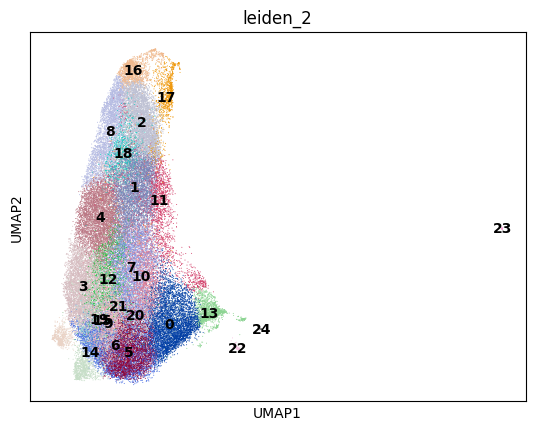

In [75]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

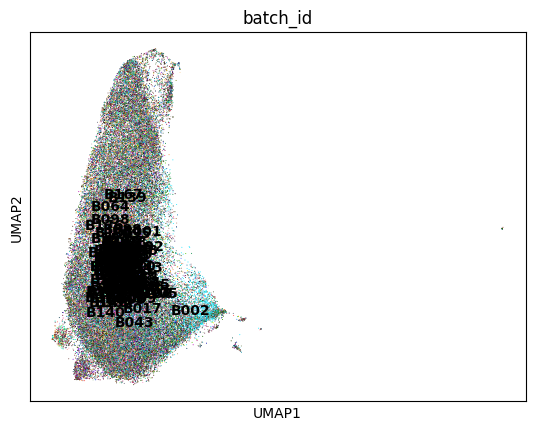

In [76]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

### Marker expression

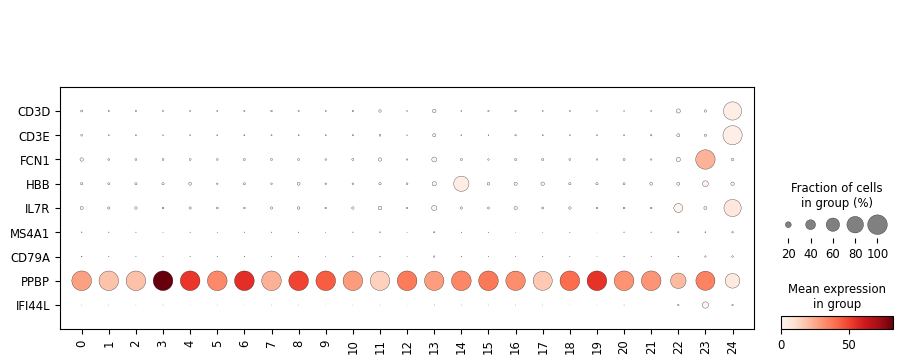

In [77]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

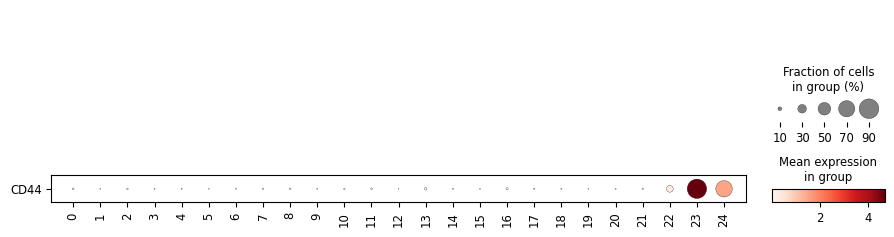

In [78]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

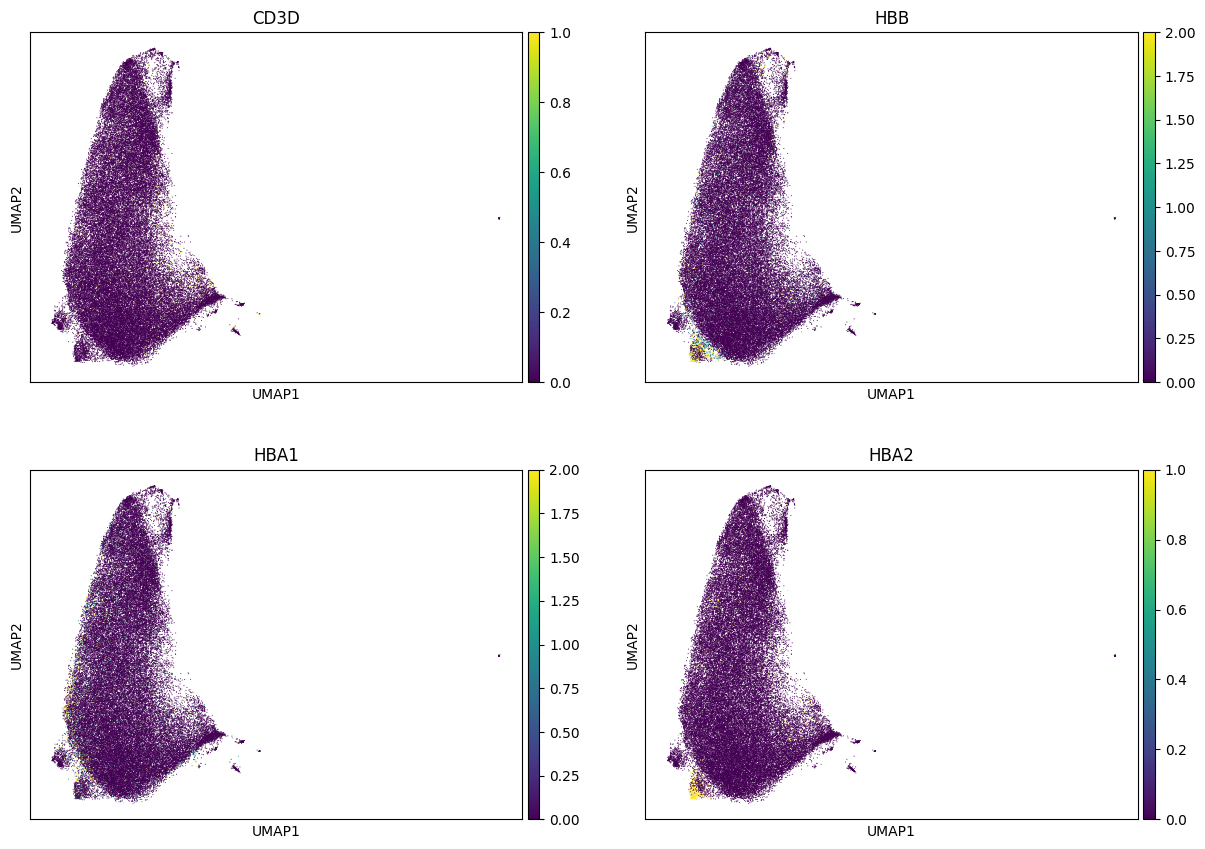

In [79]:
sc.pl.umap(adata, color = ['CD3D','HBB','HBA1','HBA2'], vmax = 'p99', ncols = 2)

### Cluster counts

In [80]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     5030
1     4730
2     4659
3     4538
4     4438
5     4355
6     4003
7     3638
8     3321
9     2937
10    2711
11    2177
12    1857
13    1681
14    1665
15    1452
16    1444
17    1073
18     905
19     799
20     794
21     381
22     220
23     105
24      31
Name: count, dtype: int64

### Outlier investigation

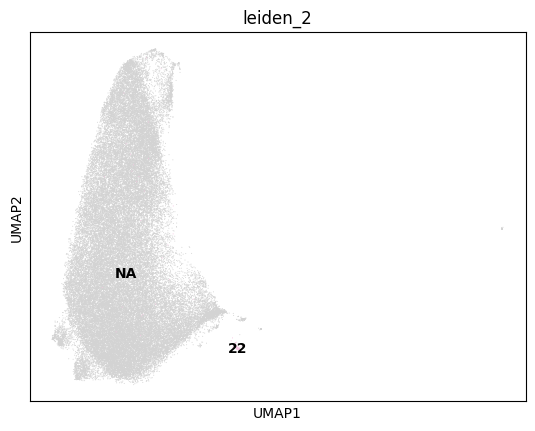

In [81]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data', groups = ['22'])

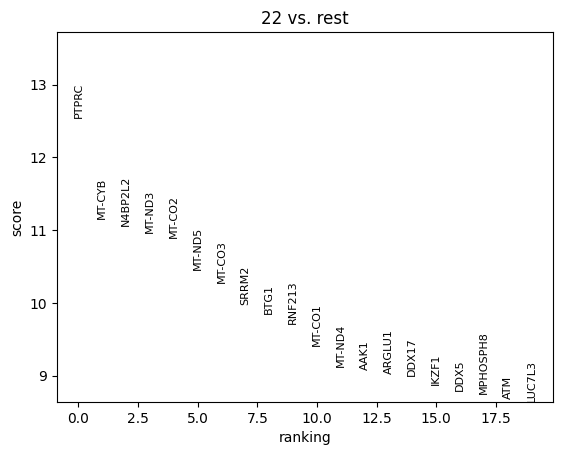

In [82]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['22']
)
sc.pl.rank_genes_groups(adata, ncols = 2)

### Comparison to original labels

In [83]:
adata = add_labels(adata, original_df)

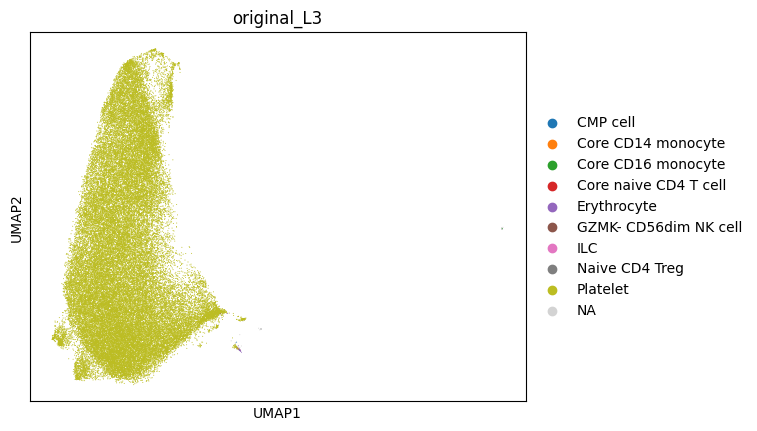

In [84]:
sc.pl.umap(adata, color = 'original_L3')

In [85]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Platelet                 58563
NaN                        353
Erythrocyte                 20
GZMK- CD56dim NK cell        2
CMP cell                     1
Core CD14 monocyte           1
Core CD16 monocyte           1
Core naive CD4 T cell        1
ILC                          1
Naive CD4 Treg               1
Name: count, dtype: int64

In [86]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Platelet                 0.993536
NaN                      0.005989
Erythrocyte              0.000339
GZMK- CD56dim NK cell    0.000034
CMP cell                 0.000017
Core CD14 monocyte       0.000017
Core CD16 monocyte       0.000017
Core naive CD4 T cell    0.000017
ILC                      0.000017
Naive CD4 Treg           0.000017
Name: count, dtype: float64

### Suggested updates
- Remove HBB+ cluster (12) as Erythrocyte doublet
- Remove FCN1+ cluster (22) as Myeloid doublet

In [87]:
os.system('jupyter nbconvert --to html --template pj 11g-Python_review_L3_other_data.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 11g-Python_review_L3_other_data.ipynb to html
[NbConvertApp] Writing 10225604 bytes to 11g-Python_review_L3_other_data.html


0

In [88]:
import session_info
session_info.show()